In [1]:
# https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

In [39]:
import pandas as pd
import numpy as np
import os
import sys
import random

import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Set some parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

NUM_TEST_IMAGES = 10

In [49]:
# get a list of files in each folder

img_list = os.listdir('C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/input')
mask_list = os.listdir('C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']



def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)


df_images.head()


,image_id,has_mask
0,img-1000Cropped.png,yes
1,img-1001Cropped.png,no
2,img-1002Cropped.png,yes
3,img-1004Cropped.png,yes
4,img-1005Cropped.png,yes


In [50]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape






(762, 3)

In [51]:
df_masks.head()

,image_id,has_mask,mask_id
0,img-1000Cropped.png,yes,img-1000Cropped.png
2,img-1002Cropped.png,yes,img-1002Cropped.png
3,img-1004Cropped.png,yes,img-1004Cropped.png
4,img-1005Cropped.png,yes,img-1005Cropped.png
5,img-1006Cropped.png,yes,img-1006Cropped.png


In [52]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(752, 3)
(10, 3)


In [53]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

In [54]:
# Get and resize train images and masks
X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)
X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


print('Getting and resizing train images and masks ... ')
sys.stdout.flush()


for n, id_ in tqdm(enumerate(image_id_list), total=len(image_id_list)):
    img = imread('C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/input/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
 
    
    for mask_file in next(os.walk('C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output/'))[2]:
        mask_ = imread('C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output/'+ mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████████████████████| 752/752 [20:28<00:00,  1.63s/it]


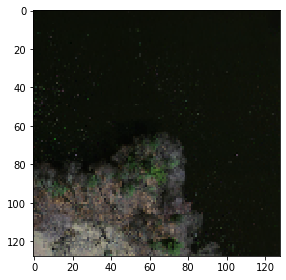

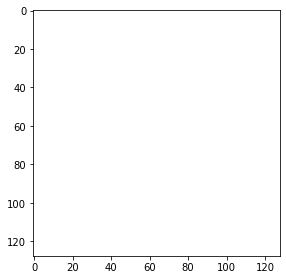

In [84]:
# Check if training data looks all right
ix = random.randint(0, 700)
imshow(X_train[ix])
plt.show()
imshow(Y_train[ix])
plt.show()

In [82]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [56]:
m = tf.keras.metrics.MeanIoU(num_classes=2)

In [57]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[m])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [65]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=700, epochs=50, 
                    callbacks=callbacks_list)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 1.0436e-06 - mean_io_u: 0.4992
Epoch 00001: val_loss improved from inf to 0.00000, saving model to model.h5
1/1 [==============================] - 1s 1s/step - loss: 1.0436e-06 - mean_io_u: 0.4992 - val_loss: 1.4901e-07 - val_mean_io_u: 0.4987
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 1.5784e-06 - mean_io_u: 0.4992
Epoch 00002: val_loss improved from 0.00000 to 0.00000, saving model to model.h5
1/1 [==============================] - 1s 1s/step - loss: 1.5784e-06 - mean_io_u: 0.4992 - val_loss: 1.4786e-07 - val_mean_io_u: 0.4987
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 8.4635e-07 - mean_io_u: 0.4992
Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to model.h5
1/1 [==============================] - 1s 1s/step - loss: 8.4635e-07 - mean_io_u: 0.4992 - val_loss: 1.4670e-07 - val_mean_io_u: 0.4987
Epoch 4/50
1/1 [==============================] - ETA: 0s - lo

In [66]:
model.load_weights('model.h5')

test_preds = model.predict(X_test)

In [67]:
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

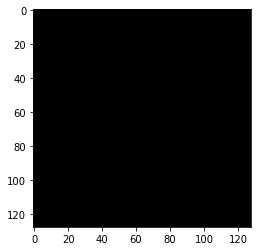

In [68]:
test_img = preds_test_thresh[5, :, :, 0]

plt.imshow(test_img, cmap='gray')

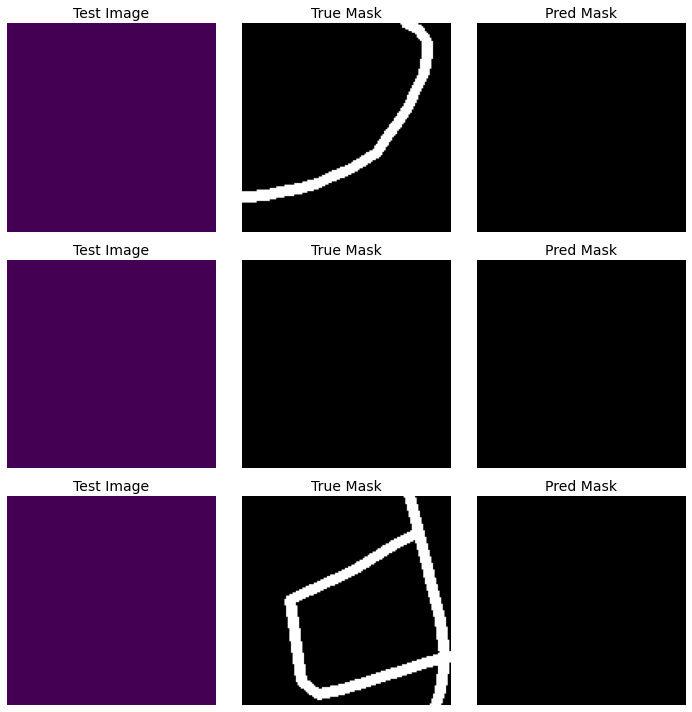

In [85]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = 'C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = 'C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = X_test[3, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[3,'mask_id']
path_mask = 'C:/Users/Phil/Desktop/Roads DataSet/road_segmentation_ideal/training/output/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = preds_test_thresh[3, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()